批量归一化:
问题: 越靠近损失的层, 训练越快; 越靠近数据的层, 训练越慢
​靠近输入的层​（如第1层）参数更新缓慢，因为后面的层需要频繁适应其变化。
​靠近输出的层​（如第10层）被迫反复学习，因为它们一直在追赶前面层的变化。
但是靠近数据的层一改变, 靠近损失的层又得重新训练, 导致这些层要学习多次, 最后使得收敛变慢

如何解决?
我们希望即使前面层的参数更新导致输出变化，输入到下一层的数据分布依然近似稳定, 每一层只需专注于学习当前的任务，不需要频繁适应前一层的变化
批量归一化在每一层的输入前插入一个“标准化+调整”的操作
输入时, 将当前输入的小批量的输入数据调整为 ​均值0、方差1

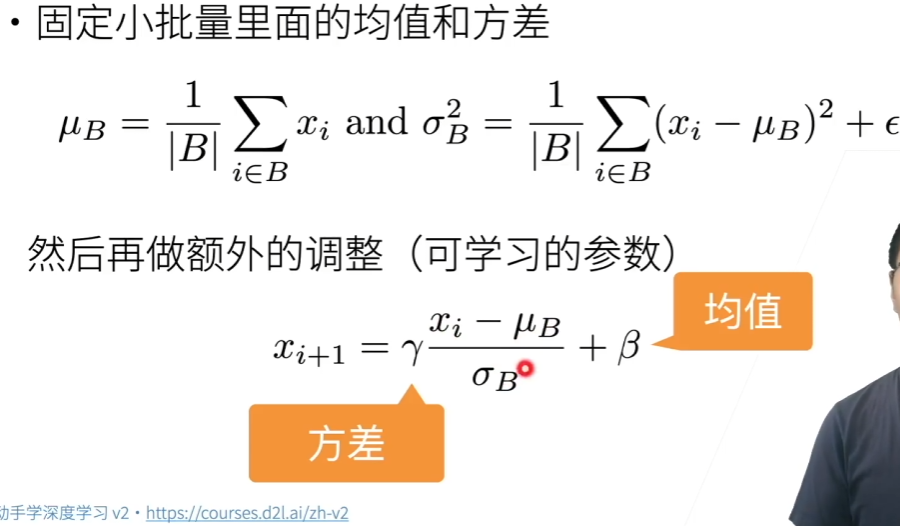

批量归一化和残差网络在外出游玩的时候看完了, 手机看的, 笔记就没写, 说一说代码实现

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

# 推理模式：当梯度计算关闭时（如模型评估），使用预计算的移动平均 moving_mean 和 moving_var 对输入 X 进行标准化
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    if not torch.is_grad_enabled():
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
# 训练模式：梯度计算开启时，动态计算当前批量的均值和方差，并更新移动平均
    else:
        assert len(X.shape) in (2, 4)
        # 全连接层（输入维度为2）​
        if len(X.shape) == 2:
            mean = X.mean(dim=0)  # 按通道维度求均值，形状 (1, C, 1, 1)
            var = ((X - mean)**2).mean(dim=0)   # 按通道维度求方差
        # 卷积层（输入维度为4）
        else:
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean)**2).mean(dim=(0, 2, 3), keepdim=True)
        X_hat = (X - mean) / torch.sqrt(var + eps)  # 利用mean和var将X标准化, 符合批量归一化的稳定形式
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean # 更新移动平均
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta # 缩放和平移
    return Y, moving_mean.data, moving_var.data

In [ ]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super().__init__()
        # 根据输入维度确定参数形状
        if num_dims == 2:
            shape = (1, num_features) # 全连接层：(batch_size, num_features)
        else:
            shape = (1, num_features, 1, 1) # 卷积层：(batch_size, channels, height, width)

        # 可学习参数：缩放gamma和偏移beta
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 移动平均统计量（非可学习参数）
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
         # 确保统计量与输入在同一设备（CPU/GPU）
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 调用批量归一化函数
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, self.moving_var,
            eps=1e-5, momentum=0.9)
        return Y

In [ ]:
# 应用BatchNorm 于LeNet模型, 可以看到我们在特定位置加入了BatchNorm层
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16,
                              kernel_size=5), BatchNorm(16, num_dims=4),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), nn.Linear(16 * 4 * 4, 120),
                    BatchNorm(120, num_dims=2), nn.Sigmoid(),
                    nn.Linear(120, 84), BatchNorm(84, num_dims=2),
                    nn.Sigmoid(), nn.Linear(84, 10))

In [ ]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 拉伸参数 gamma 和偏移参数 beta
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

In [ ]:
# 简明实现, 我们加入了BatchNorm层时可以少填一个参数了
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), nn.Linear(256, 120), nn.BatchNorm1d(120),
                    nn.Sigmoid(), nn.Linear(120, 84), nn.BatchNorm1d(84),
                    nn.Sigmoid(), nn.Linear(84, 10))

ResNet: 解决层数越深, 越最优解越远离实际值的问题

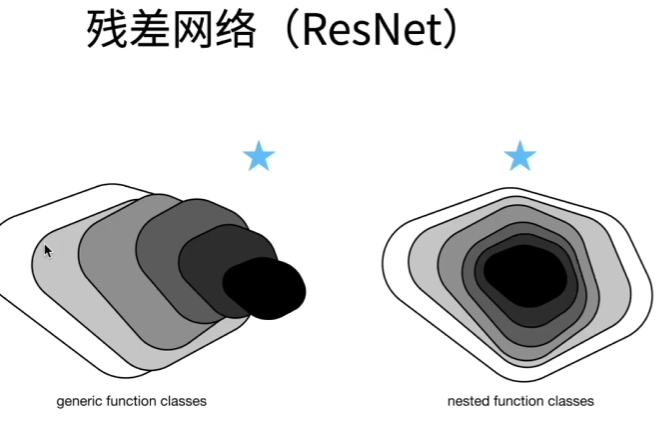

对于这一层的学习, 我们可以构造个跳跃的连接, 让上一层的输出影响下一层的输入, 这样可以防止 "这一层什么都没学到" 的情况

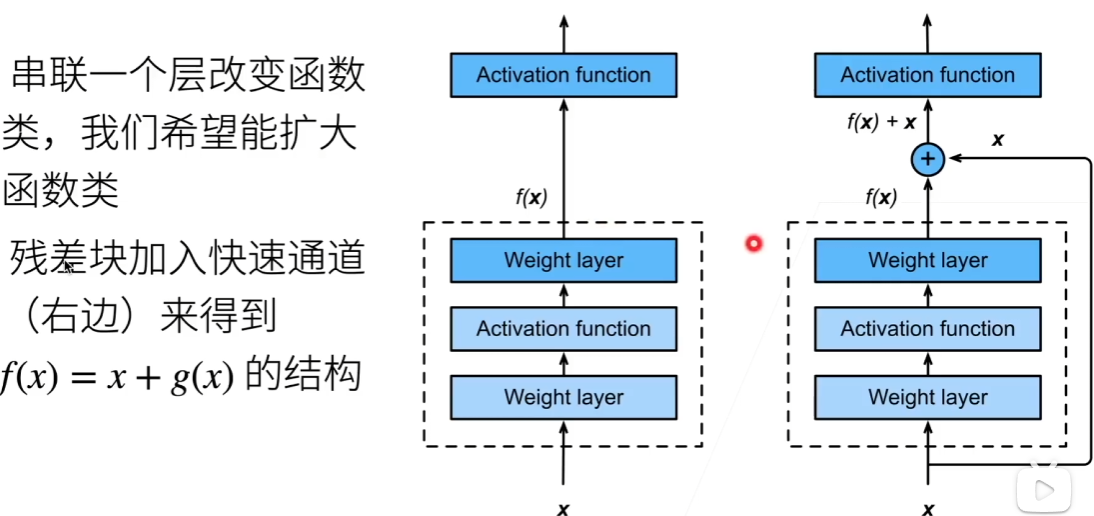

对宽高影响不同的resnet
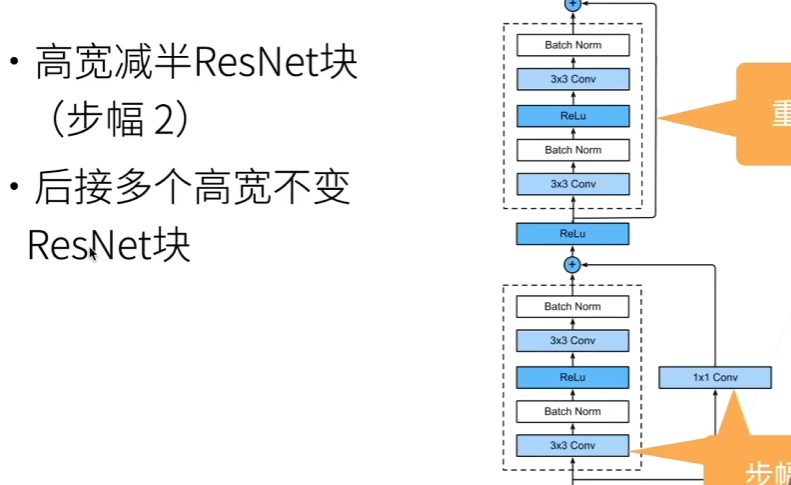
多个种类的resnet
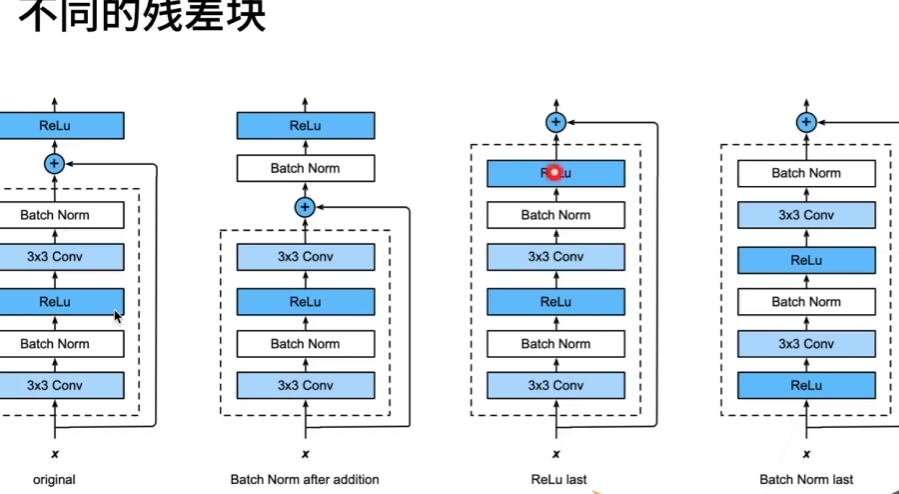

In [ ]:
# ResNet的代码实现
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False,
                 strides=1):
        super().__init__()
        # 主路径：两个卷积层 + 批归一化
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3,
                               padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3,
                               padding=1)
        # 跳跃连接：1x1卷积调整通道数和空间尺寸（可选）
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        # 批归一化和激活函数
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X))) # 主路径第一层：卷积 → BN → ReLU
        Y = self.bn2(self.conv2(Y))  # 主路径第二层：卷积 → BN
        if self.conv3:   # 调整输入形状以匹配主路径输出
            X = self.conv3(X)
        Y += X  # 残差连接：跳跃连接
        return F.relu(Y)

In [ ]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(
                Residual(input_channels, num_channels, use_1x1conv=True,
                         strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

net = nn.Sequential(b1, b2, b3, b4, b5, nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten(), nn.Linear(512, 10))

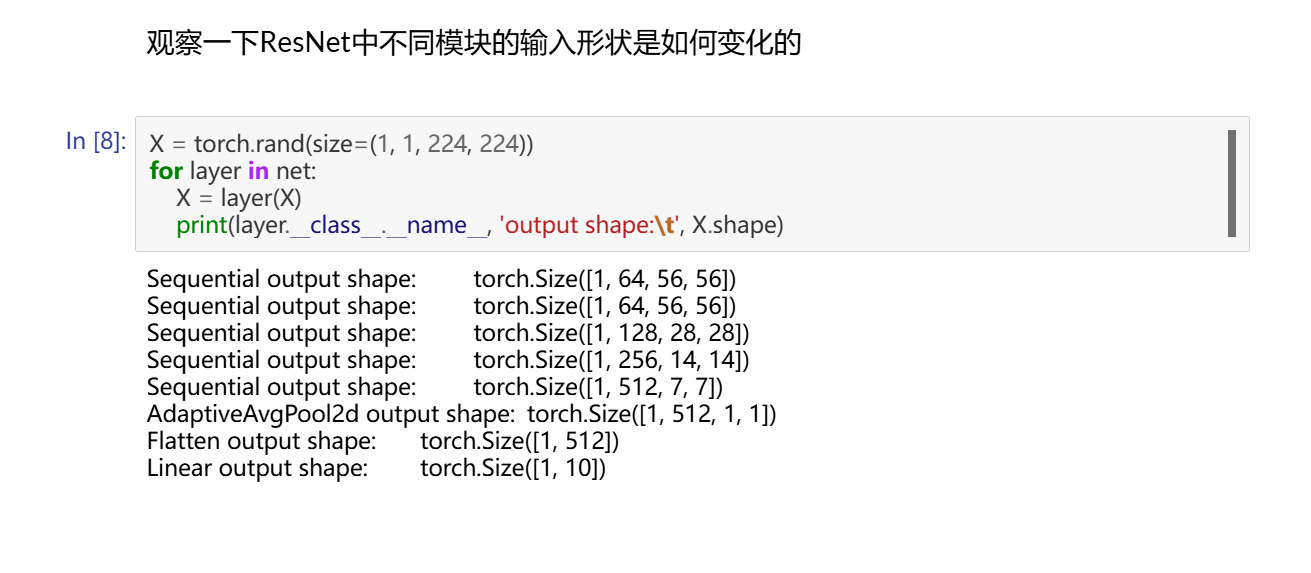

In [ ]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

对resnet使用模式的理解:
y'' = f(x) + g(f(x))
则 y''关于w的梯度 = y关于w的梯度 + y'关于w的梯度
(如果不使用resnet的话, y''关于w的梯度 = y'关于w的梯度, 可能会出现学不到什么东西的情况)

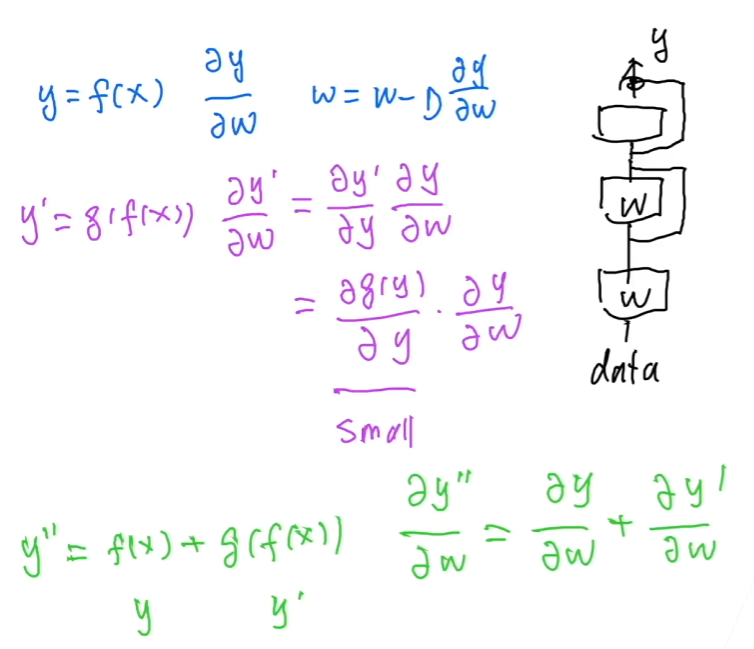